Задачей проекта является разработка модели, которая будет предсказывать стоимость недвижимости, основываясь на ее характеристиках. Для оценки качества модели будут использоваться метрики MAE (Mean Absolute Error) – это среднее арифметическое модуля отклонения предсказанного значения от реального и MAPE (Mean Absolute Percent Error), которая показывает на сколько процентов в среднем предсказание модели отклоняется от реального значения, R2 - это коэффициент детерминации и RMSE (Root Mean Square Error) - это корень из средней квадратической ошибки. Перечислим признаки, которые содержатся в имеющихся данных и по которым будет обучаться модель:

статус продажи <br>
наличие бассейна <br>
тип недвижимости <br>
адрес <br>
количество ванных комнат <br>
год постройки дома <br>
год реконструкции <br>
тип отопления <br>
тип кондиционирования <br>
вид парковки автомобиля <br>
площадь земельного участка, прилагающегося к дому <br>
цена единицы площади участка <br>
наличие камина в доме <br>
город, в котором расположен дом <br>
рейтинги близлежащих школ <br>
расстояния до близлежащих школ <br>
жилая площадь <br>
количество спальных комнат <br>
штат, в котором расположен дом <br>
количество этажей <br>
уникальный идентификатор продажи <br>
стоимость дома <br>

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Анализ и очистка данных

In [505]:
estate_data = pd.read_csv('data.csv/data.csv')

In [506]:
estate_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [507]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [508]:
# Определим количество нулей в столбцах
estate_data.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

In [509]:
# Определение выбросов при помощи фильтрации данных по условию выхода за пределы верхней или нижней границы.

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [510]:
# Поиск выбросов методом z-отклонений

def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

### Status

In [511]:
# Определим сумму нулевых значений в столбце "Status"
estate_data['status'].isna().sum()

39918

In [512]:
# Посмотрим 50 самых больших значений столбца "Status"
estate_data['status'].value_counts()[:50]

for sale                             156104
Active                               105207
For sale                              43465
foreclosure                            6426
New construction                       5475
Pending                                4702
Pre-foreclosure                        2119
Pre-foreclosure / auction              1560
P                                      1488
Under Contract Show                    1183
 / auction                              936
Under Contract   Showing                793
Active Under Contract                   718
Under Contract                          690
New                                     690
Contingent                              581
Price Change                            563
Auction                                 536
Foreclosed                              459
A Active                                443
for rent                                398
Foreclosure                             343
recently sold                   

In [513]:
# Заполним нулевые значения на 'no_provided'

estate_data['status'] = estate_data['status'].fillna('no_provided')

In [514]:
# Приведение к нижнему регистру
estate_data['status'] = estate_data['status'].apply(lambda x: str(x).lower())

In [515]:
# Проверим изменение в количестве значений столбца "Status"
estate_data['status'].value_counts()[:50]

for sale                             199571
active                               105207
no_provided                           39918
foreclosure                            6769
new construction                       5475
pending                                4807
pre-foreclosure                        2119
pre-foreclosure / auction              1560
p                                      1488
under contract show                    1183
 / auction                              936
under contract   showing                793
active under contract                   718
under contract                          692
new                                     690
contingent                              581
price change                            563
auction                                 536
foreclosed                              459
a active                                443
for rent                                398
recently sold                           287
under contract backups          

In [516]:
# Приведение значения к одному названию

estate_data['status'] = estate_data['status'].apply(lambda x: 'foreclosure' if x == 'foreclosed' else x)

In [517]:
estate_data['status'] = estate_data['status'].apply(lambda x: 'new construction' if x == 'new' else x)

In [518]:
estate_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [519]:
# Проверим изменение в количестве значений столбца "Status"
estate_data['status'].value_counts()[:50]

for sale                             199571
active                               105207
no_provided                           39918
foreclosure                            7228
new construction                       6165
pending                                4807
pre-foreclosure                        2119
pre-foreclosure / auction              1560
p                                      1488
under contract show                    1183
 / auction                              936
under contract   showing                793
active under contract                   718
under contract                          692
contingent                              581
price change                            563
auction                                 536
a active                                443
for rent                                398
recently sold                           287
under contract backups                  252
contingent finance and inspection       245
pending continue to show        

In [520]:
estate_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [521]:
# Найдем самые популярные значения в столбце описывающие 60% всего датасета.

freq_status = list(estate_data['status'].value_counts())
percentile = int(np.percentile(freq_status, 60))
percentile

7

In [522]:
estate_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [523]:
# Оставим 7 значений, остальные удалим

In [524]:
all_statuses = set(estate_data['status'].value_counts().index)
main_statuses = set(estate_data['status'].value_counts().index[:7])
statuses_to_drop = list(all_statuses - main_statuses)
estate_data.drop(estate_data.loc[estate_data['status'].isin(statuses_to_drop), 'status'].index, inplace = True)

estate_data.reset_index(inplace = True, drop = True)

In [525]:
estate_data['status'].value_counts(normalize=True)

for sale            0.546747
active              0.288227
no_provided         0.109360
foreclosure         0.019802
new construction    0.016890
pending             0.013169
pre-foreclosure     0.005805
Name: status, dtype: float64

In [526]:
estate_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [527]:
estate_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [528]:
# Удалим столбец с информацией о улице, так как он не даст объективной информации для модели
estate_data.drop('street', axis=1, inplace=True)

In [529]:
estate_data.shape

(365015, 17)

In [530]:
estate_data.head()

,status,private pool,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,NaN,Single Family Home,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [531]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365015 entries, 0 to 365014
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        365015 non-null  object
 1   private pool  3992 non-null    object
 2   propertyType  330424 non-null  object
 3   baths         260606 non-null  object
 4   homeFacts     365015 non-null  object
 5   fireplace     97940 non-null   object
 6   city          364982 non-null  object
 7   schools       365015 non-null  object
 8   sqft          325170 non-null  object
 9   zipcode       365015 non-null  object
 10  beds          274914 non-null  object
 11  state         365015 non-null  object
 12  stories       218893 non-null  object
 13  mls-id        24894 non-null   object
 14  PrivatePool   40090 non-null   object
 15  MlsId         301691 non-null  object
 16  target        363295 non-null  object
dtypes: object(17)
memory usage: 47.3+ MB


### Private pool

In [532]:
# В датасете есть два столбца относящиеся к Private pool. Проведем необходимую подготовку данных
# и объеденим два столбца.

In [533]:
estate_data['private pool'].isna().sum()

361023

In [534]:
estate_data['private pool'] = estate_data['private pool'].fillna('')

In [535]:
estate_data.isna().sum()

status               0
private pool         0
propertyType     34591
baths           104409
homeFacts            0
fireplace       267075
city                33
schools              0
sqft             39845
zipcode              0
beds             90101
state                0
stories         146122
mls-id          340121
PrivatePool     324925
MlsId            63324
target            1720
dtype: int64

In [536]:
estate_data.head()

,status,private pool,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,active,,Single Family Home,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,,lot/land,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [537]:
estate_data['private pool'].isna().sum()

0

In [538]:
estate_data['private pool'].value_counts(normalize=True)

       0.989063
Yes    0.010937
Name: private pool, dtype: float64

In [539]:
estate_data['PrivatePool'].value_counts(normalize=True)

yes    0.714567
Yes    0.285433
Name: PrivatePool, dtype: float64

In [540]:
estate_data['PrivatePool'].isna().sum()

324925

In [541]:
estate_data['PrivatePool'] = estate_data['PrivatePool'].fillna('')

In [542]:
estate_data.isna().sum()

status               0
private pool         0
propertyType     34591
baths           104409
homeFacts            0
fireplace       267075
city                33
schools              0
sqft             39845
zipcode              0
beds             90101
state                0
stories         146122
mls-id          340121
PrivatePool          0
MlsId            63324
target            1720
dtype: int64

In [543]:
# Объеденим данные двух столбцов 'PrivatePool' и 'private pool'
estate_data['Pool'] = estate_data['PrivatePool'] + estate_data['private pool']

In [544]:
estate_data.isna().sum()

status               0
private pool         0
propertyType     34591
baths           104409
homeFacts            0
fireplace       267075
city                33
schools              0
sqft             39845
zipcode              0
beds             90101
state                0
stories         146122
mls-id          340121
PrivatePool          0
MlsId            63324
target            1720
Pool                 0
dtype: int64

In [545]:
estate_data['Pool'].value_counts(normalize=True)

       0.879232
yes    0.078482
Yes    0.042286
Name: Pool, dtype: float64

In [546]:
estate_data['Pool'].value_counts(normalize=True)

       0.879232
yes    0.078482
Yes    0.042286
Name: Pool, dtype: float64

In [547]:
estate_data['Pool'] = estate_data['Pool'].replace(r'^\s*$', 'No', regex=True)

In [548]:
estate_data['Pool'].value_counts(normalize=True)

No     0.879232
yes    0.078482
Yes    0.042286
Name: Pool, dtype: float64

In [549]:
estate_data['Pool'] = estate_data['Pool'].replace('yes', 'Yes', regex=True)

In [550]:
estate_data['Pool'].value_counts(normalize=True)

No     0.879232
Yes    0.120768
Name: Pool, dtype: float64

In [551]:
# Удалим одиночные столбцы 'private pool' и 'PrivatePool'

estate_data = estate_data.drop(['private pool','PrivatePool'], axis=1)

In [552]:
estate_data.head()

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,Pool
0,active,Single Family Home,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,611019,"$418,000",No
1,for sale,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,201916904,"$310,000",No
2,for sale,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,FR19221027,"$2,895,000",Yes
3,for sale,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,14191809,"$2,395,000",No
4,for sale,lot/land,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,861745,"$5,000",No


In [553]:
estate_data.loc[4]

status                                                   for sale
propertyType                                             lot/land
baths                                                         NaN
homeFacts       {'atAGlanceFacts': [{'factValue': '', 'factLab...
fireplace                                                     NaN
city                                                     Palm Bay
schools         [{'rating': ['4/10', '5/10', '5/10'], 'data': ...
sqft                                                          NaN
zipcode                                                     32908
beds                                                          NaN
state                                                          FL
stories                                                       NaN
mls-id                                                        NaN
MlsId                                                      861745
target                                                     $5,000
Pool      

In [554]:
# Удалим информацию о зипкоде, mls-od и штате так как они не дают объективную информацию для модели
estate_data = estate_data.drop(['zipcode', 'mls-id', 'MlsId', 'state'], axis=1)

In [555]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365015 entries, 0 to 365014
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        365015 non-null  object
 1   propertyType  330424 non-null  object
 2   baths         260606 non-null  object
 3   homeFacts     365015 non-null  object
 4   fireplace     97940 non-null   object
 5   city          364982 non-null  object
 6   schools       365015 non-null  object
 7   sqft          325170 non-null  object
 8   beds          274914 non-null  object
 9   stories       218893 non-null  object
 10  target        363295 non-null  object
 11  Pool          365015 non-null  object
dtypes: object(12)
memory usage: 33.4+ MB


In [556]:
estate_data.head()

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,beds,stories,target,Pool
0,active,Single Family Home,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4,NaN,"$418,000",No
1,for sale,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3 Beds,2.0,"$310,000",No
2,for sale,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",3 Beds,1.0,"$2,895,000",Yes
3,for sale,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",5 Beds,3.0,"$2,395,000",No
4,for sale,lot/land,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,NaN,NaN,"$5,000",No


In [557]:
# Оставляем признаки, в которых общее количество пропущенных значений меньше 4-х

estate_data = estate_data[~(estate_data.isna().sum(axis=1) >= 4)]

In [558]:
estate_data[estate_data.isna().sum(axis=1) >= 3]

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,beds,stories,target,Pool
6,active,Florida,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",NaN,One,"181,500",No
11,active,English,NaN,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...","3,130",NaN,2,"260,000",No
16,active,NaN,"1,750","{'atAGlanceFacts': [{'factValue': '2008', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['4', 'NR', '3', 'NR'], 'data': {'...","2,203",Baths,NaN,"335,000",No
35,for sale,condo,NaN,"{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,Charlotte,"[{'rating': ['7/10', '4/10', '8/10'], 'data': ...",900 sqft,2 Beds,NaN,"$260,000",No
60,for sale,lot/land,NaN,"{'atAGlanceFacts': [{'factValue': '1974', 'fac...",NaN,Atlanta,"[{'rating': ['8/10', '6/10', '8/10'], 'data': ...","1,076 sqft",NaN,2.0,"$369,900",No
...,...,...,...,...,...,...,...,...,...,...,...,...
364903,for sale,coop,NaN,"{'atAGlanceFacts': [{'factValue': '1931', 'fac...",NaN,Woodside,"[{'rating': ['3/10', '3/10', '8/10'], 'data': ...","409,538 sqft",NaN,1.0,"$335,000",No
364929,pending,Land,0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Port Charlotte,"[{'rating': ['6', '4', '6', '5', '7', '5', 'NR...",0,NaN,NaN,"$7,000",No
364939,for sale,condo,NaN,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",801 sqft,2 Beds,NaN,"$399,000",No
364949,for sale,single-family home,NaN,"{'atAGlanceFacts': [{'factValue': '1930', 'fac...",NaN,Staten Island,"[{'rating': ['4/10', '3/10', '4/10'], 'data': ...","1,389 sqft",NaN,3.0,"$380,000",No


In [559]:
estate_data['sqft']


0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
5           897 sqft
             ...    
365009         1,417
365010         4,017
365011    2,000 sqft
365012    1,152 sqft
365014         1,462
Name: sqft, Length: 293703, dtype: object

### homeFacts

In [560]:
# Посмотрим полностью одну колонку из столбца "homeFacts"

estate_data['homeFacts'][100]

"{'atAGlanceFacts': [{'factValue': '1949', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Other', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '0.92 acres lot', 'factLabel': 'lotsize'}, {'factValue': '$53', 'factLabel': 'Price/sqft'}]}"

In [561]:
estate_data['homeFacts']

0         {'atAGlanceFacts': [{'factValue': '2019', 'fac...
1         {'atAGlanceFacts': [{'factValue': '2019', 'fac...
2         {'atAGlanceFacts': [{'factValue': '1961', 'fac...
3         {'atAGlanceFacts': [{'factValue': '2006', 'fac...
5         {'atAGlanceFacts': [{'factValue': '1920', 'fac...
                                ...                        
365009    {'atAGlanceFacts': [{'factValue': '2010', 'fac...
365010    {'atAGlanceFacts': [{'factValue': '1990', 'fac...
365011    {'atAGlanceFacts': [{'factValue': '1924', 'fac...
365012    {'atAGlanceFacts': [{'factValue': '1950', 'fac...
365014    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
Name: homeFacts, Length: 293703, dtype: object

In [562]:
estate_data.isna().sum()

status               0
propertyType      5903
baths            34528
homeFacts            0
fireplace       196847
city                 9
schools              0
sqft              2171
beds             25117
stories          79682
target            1196
Pool                 0
dtype: int64

In [563]:
# В строке закодирован словарь. Применим функцию eval для раскодировки словаря.

estate_data['homeFacts'] = estate_data['homeFacts'].apply(eval)

In [564]:
estate_data['homeFacts'][0]

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

In [565]:
# извлечем из словаря данные о годе постройки и создадим признак "Year_built"

estate_data['Year_built'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [566]:
estate_data['Year_built']

0         2019
1         2019
2         1961
3         2006
5         1920
          ... 
365009    2010
365010    1990
365011    1924
365012    1950
365014    2019
Name: Year_built, Length: 293703, dtype: object

In [567]:
# посмотрим на уникальные значения столбца и определим выходящие из формата
estate_data['Year_built'].unique()

array(['2019', '1961', '2006', '1920', '1970', '1965', '2015', '1996',
       '1982', '2008', '2016', '1954', '1989', '2014', '1915', '', '1994',
       '1910', '1923', '1960', '1977', '1972', '1963', '1981', '1949',
       '1930', '1991', '1958', '2005', '2017', '2018', '1983', '1928',
       '1997', '1964', '1974', '1940', '1973', '1968', '1999', '1918',
       '2007', '1984', '1946', '2003', '2000', '2004', '1969', '1947',
       '2002', '1978', '1956', '1967', '1975', '1988', '1955', '1950',
       '1959', '2012', '1924', '1992', '2001', '1985', '2010', '1971',
       '1909', '1953', '1993', '1990', '1957', '1995', '1998', '1980',
       '1951', '1907', '1885', '1941', '1927', '1929', '1901', '1976',
       '1922', '1906', '1945', '1979', '2009', None, '1913', '2011',
       '1897', '1987', '2020', '1926', '1952', '1925', '1962', '2013',
       '1943', '1966', '1890', '1900', '1895', '1911', '1948', 'No Data',
       '1942', '1935', '1986', '1931', '1944', '1916', '1893', '1879',
 

In [568]:
estate_data = estate_data.drop(estate_data[estate_data['Year_built'] == '559990649990'].index)

In [569]:
estate_data['Year_built'].unique()

array(['2019', '1961', '2006', '1920', '1970', '1965', '2015', '1996',
       '1982', '2008', '2016', '1954', '1989', '2014', '1915', '', '1994',
       '1910', '1923', '1960', '1977', '1972', '1963', '1981', '1949',
       '1930', '1991', '1958', '2005', '2017', '2018', '1983', '1928',
       '1997', '1964', '1974', '1940', '1973', '1968', '1999', '1918',
       '2007', '1984', '1946', '2003', '2000', '2004', '1969', '1947',
       '2002', '1978', '1956', '1967', '1975', '1988', '1955', '1950',
       '1959', '2012', '1924', '1992', '2001', '1985', '2010', '1971',
       '1909', '1953', '1993', '1990', '1957', '1995', '1998', '1980',
       '1951', '1907', '1885', '1941', '1927', '1929', '1901', '1976',
       '1922', '1906', '1945', '1979', '2009', None, '1913', '2011',
       '1897', '1987', '2020', '1926', '1952', '1925', '1962', '2013',
       '1943', '1966', '1890', '1900', '1895', '1911', '1948', 'No Data',
       '1942', '1935', '1986', '1931', '1944', '1916', '1893', '1879',
 

In [570]:
# Заменим пустые значения, 'No Data' на None
estate_data['Year_built'] = estate_data['Year_built'].apply(lambda x: None if (x == '') | (x == 'No Data') else x)

In [571]:
# Перевод столбца в числовой формат
estate_data['Year_built'] = estate_data['Year_built'].apply(lambda x: int(x) if x != None else x)

In [572]:
type(estate_data['Year_built'][0])

numpy.float64

In [573]:
# Подсчитаем общее количество пропусков
estate_data['Year_built'].isna().sum()

23031

In [574]:
# Найдем среднее значение для столбца
round(estate_data['Year_built'].median())

1986

In [575]:
# Заполним пропуски средним значением для столбца
estate_data['Year_built'] = estate_data['Year_built'].fillna(1986)

In [576]:
estate_data['Year_built'].isna().sum()

0

In [577]:
#estate_data['Year_built'].loc[outliers_iqr(estate_data.year_built)].sort_values()

In [578]:
# Удаление выбросов
#estate_data = estate_data.drop(outliers_iqr(estate_data['Year_built']))
#estate_data.reset_index(inplace = True, drop = True)

In [579]:
len(estate_data[estate_data['Year_built'] > 2023])

2

In [580]:
# Построим гистограмму распределения

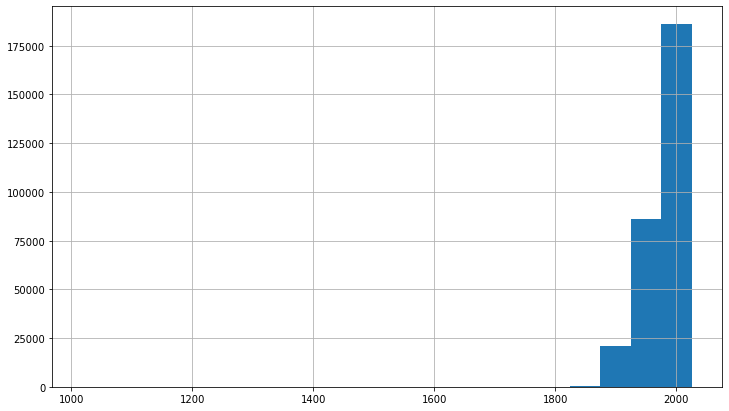

In [581]:
plt.figure(figsize=(12, 7))
estate_data.Year_built.hist(bins=20);

In [582]:
# Извлечем из словаря год перепланировки

estate_data['remodeled_year'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [583]:
estate_data['remodeled_year'].nunique()

151

In [584]:
estate_data['remodeled_year'].isna().sum()

22890

In [585]:
estate_data['remodeled_year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '2009',
       '1996', '1995', '1988', '1972', '1949', '1954', '1930', '2000',
       '1994', '2005', '1983', '2003', '1965', '1968', '1993', '1999',
       '2014', '2010', '2004', '2007', '1978', '1947', '1950', '2002',
       '1973', '1970', '1989', '1980', '1986', '2008', '1955', '1991',
       '2011', '2017', '2016', '1941', '2001', '1990', '1901', '1984',
       '1918', '1956', '2013', '1960', '1981', '1969', '1987', '1998',
       '1958', '1925', '1975', '1966', '1992', '1943', '1977', '1979',
       '1961', '1948', '1952', '1931', '2012', '1976', '1935', '1910',
       '1940', '1957', '1971', '1916', '1963', '1974', '2018', '1985',
       '1951', '1962', '1964', '1942', '1959', '1927', '1946', '1945',
       '1920', '1938', '1936', '0', '1939', '1915', '1928', '1923',
       '1944', '1929', '1898', '1934', '1953', '1926', '1937', '1899',
       '1912', '1917', '1906', '1932', '1905', '1919', '1921', '1924',
       

In [586]:
# Приведем пустые значения к нулю
estate_data['remodeled_year'] = estate_data['remodeled_year'].apply(lambda x: '0' if x == '' else x)

In [587]:
estate_data['remodeled_year'] = estate_data['remodeled_year'].fillna('0')

In [589]:
estate_data['remodeled_year'].unique()

array(['0', '1967', '2006', '2015', '1997', '2019', '1982', '2009',
       '1996', '1995', '1988', '1972', '1949', '1954', '1930', '2000',
       '1994', '2005', '1983', '2003', '1965', '1968', '1993', '1999',
       '2014', '2010', '2004', '2007', '1978', '1947', '1950', '2002',
       '1973', '1970', '1989', '1980', '1986', '2008', '1955', '1991',
       '2011', '2017', '2016', '1941', '2001', '1990', '1901', '1984',
       '1918', '1956', '2013', '1960', '1981', '1969', '1987', '1998',
       '1958', '1925', '1975', '1966', '1992', '1943', '1977', '1979',
       '1961', '1948', '1952', '1931', '2012', '1976', '1935', '1910',
       '1940', '1957', '1971', '1916', '1963', '1974', '2018', '1985',
       '1951', '1962', '1964', '1942', '1959', '1927', '1946', '1945',
       '1920', '1938', '1936', '1939', '1915', '1928', '1923', '1944',
       '1929', '1898', '1934', '1953', '1926', '1937', '1899', '1912',
       '1917', '1906', '1932', '1905', '1919', '1921', '1924', '1907',
       '1

In [590]:
# Приведем столбец в числовой формат 
estate_data['remodeled_year'] = estate_data['remodeled_year'].apply(lambda x: int(x))

In [591]:
estate_data['remodeled_year'].unique()

array([   0, 1967, 2006, 2015, 1997, 2019, 1982, 2009, 1996, 1995, 1988,
       1972, 1949, 1954, 1930, 2000, 1994, 2005, 1983, 2003, 1965, 1968,
       1993, 1999, 2014, 2010, 2004, 2007, 1978, 1947, 1950, 2002, 1973,
       1970, 1989, 1980, 1986, 2008, 1955, 1991, 2011, 2017, 2016, 1941,
       2001, 1990, 1901, 1984, 1918, 1956, 2013, 1960, 1981, 1969, 1987,
       1998, 1958, 1925, 1975, 1966, 1992, 1943, 1977, 1979, 1961, 1948,
       1952, 1931, 2012, 1976, 1935, 1910, 1940, 1957, 1971, 1916, 1963,
       1974, 2018, 1985, 1951, 1962, 1964, 1942, 1959, 1927, 1946, 1945,
       1920, 1938, 1936, 1939, 1915, 1928, 1923, 1944, 1929, 1898, 1934,
       1953, 1926, 1937, 1899, 1912, 1917, 1906, 1932, 1905, 1919, 1921,
       1924, 1907, 1911, 1900, 1889, 1913, 1895, 1908, 1903, 1904, 1933,
       1894, 1892, 1914, 1922, 1902, 1909, 1877, 2020, 1880, 1893, 1890,
       1891, 1884, 2021, 1897, 1886, 1846, 1896, 1885, 1870, 1883, 1887,
       1853, 1888, 1800, 1738, 1876, 1874, 1862], d

In [592]:
type(estate_data['remodeled_year'][0])

numpy.int64

In [593]:
# Сколько нулевых значений в столбце.

len(estate_data[estate_data['remodeled_year'] == 0])

163576

In [594]:
# Закодируем в бинарный признак, создадим новый столбец

estate_data['remodeled'] = estate_data['remodeled_year'].apply(lambda x: 'yes' if x > 0 else 'no')

In [595]:
estate_data.drop('remodeled_year', axis=1, inplace=True)

In [596]:
estate_data['remodeled'].value_counts()

no     163576
yes    130125
Name: remodeled, dtype: int64

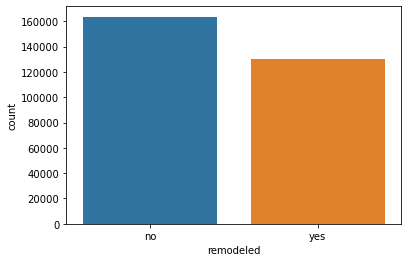

In [597]:
# Посмотрим гистограмму распределения
sns.countplot(x = 'remodeled', data = estate_data);

In [598]:
estate_data['homeFacts'][1]

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': '', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': '5828 sqft', 'factLabel': 'lotsize'},
  {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}

In [599]:
# Извлечем следующий признак из словаря - heating
estate_data['heating'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])

In [600]:
estate_data['heating'].nunique()

1723

In [601]:
estate_data['heating'].unique()

array(['Central A/C, Heat Pump', '', 'Forced Air', ...,
       'Floor Furnace, Wall Electric, Wall Gas',
       'Other Cooling (See Remarks)',
       'Baseboard, Hot Water, Programmable Thermostat, Radiant Floor'],
      dtype=object)

In [602]:
# посмотрим 50 основных значений столбца
estate_data['heating'].value_counts()[:50]

Forced Air                               80203
                                         56746
Forced air                               49960
Other                                    27708
No Data                                   8279
Gas                                       7064
Electric                                  6776
Central Electric                          6694
Heat Pump                                 5904
Central                                   4221
Baseboard                                 3550
Central, Electric                         3315
Wall                                      3095
Heat pump                                 2638
Heating System                            1966
Electric Heat                             1913
Forced air, Heat pump                     1709
Central Air                               1540
Radiant                                   1418
Central Furnace                            849
Central Electric, Zoned                    835
Natural Gas H

In [603]:
# Приведем значения к нижнему регистру
estate_data['heating'] = estate_data['heating'].apply(lambda x: str(x).lower())

In [604]:
estate_data['heating'] = estate_data['heating'].fillna('no_provided')

In [605]:
estate_data['heating'].value_counts()[:50]

forced air                               130163
                                          56746
other                                     27708
heat pump                                  8542
no data                                    8279
gas                                        7066
electric                                   6782
central electric                           6694
central                                    4221
baseboard                                  3550
central, electric                          3315
wall                                       3095
heating system                             1966
electric heat                              1913
forced air, heat pump                      1747
central air                                1540
radiant                                    1418
central furnace                             849
central electric, zoned                     835
natural gas heat                            780
forced air heating                      

In [606]:
# Заменим пустую строку ' ' и значение 'no data' на значение 'no info'. 
# Также значения 'central air', 'forced air heating' и 'central air, ceiling fan(s)' заменим на 'forced air', 
# значения 'central electric', 'electric heat', 'central, electric' и 'central electric, zoned' на 'electric',
# значения 'natural gas heat', 'gas heat', 'natural gas', 'central gas' и 'central, gas' на 'gas', значение ',
# heat pump - heat' и 'central, heat pump' на 'heat pump'.

In [607]:
estate_data['heating'] = estate_data['heating'].apply(lambda x: 'no_info' if (x == '') | (x == 'no_provided') else x)

In [608]:
estate_data['heating'] = estate_data['heating'].apply(lambda x: 'forced_air' if (x == 'forced air heating') | (x == 'forced air, heat pump, stove') | (x == 'central air') | (x == 'forced air, wall') else x)

In [609]:
estate_data['heating'] = estate_data['heating'].apply(lambda x: 'electric' if (x == 'central electric') | (x == 'central electric') | (x == 'central electric, heat pump') | (x == 'central, electric, two or more units') | (x == 'central heating') | ( x == 'central') else x)

In [610]:
estate_data['heating'] = estate_data['heating'].apply(lambda x: 'gas' if (x == 'gas heat') | (x == 'central gas') | (x == 'central, gas') else x)

In [611]:
estate_data['heating'] = estate_data['heating'].apply(lambda x: 'heat pump' if (x == ', heat pump - heat') | (x == 'central, heat pump') else x)

In [612]:
estate_data['heating'].value_counts()[:50]

forced air                               130163
no_info                                   56746
other                                     27708
electric                                  18906
heat pump                                  9024
gas                                        8600
no data                                    8279
baseboard                                  3550
central, electric                          3315
wall                                       3095
forced_air                                 2442
heating system                             1966
electric heat                              1913
forced air, heat pump                      1747
radiant                                    1418
central furnace                             849
central electric, zoned                     835
natural gas heat                            780
none                                        611
forced air, natural gas                     547
, gas hot air/furnace                   

In [613]:
freq_heating = list(estate_data['heating'].value_counts())

In [614]:
# определим признаки, которые включают 85% всего столбца
top_heating = int(np.percentile(freq_heating, 85))
top_heating

6

In [615]:
# отставим основные 6 значений и удалим остальные
all_heatingTypes = set(estate_data.heating.value_counts().index)
main_heatingTypes = set(estate_data.heating.value_counts().index[:6])
heatingTypes_to_drop = list(all_heatingTypes - main_heatingTypes)
estate_data.drop(estate_data.loc[estate_data['heating'].isin(heatingTypes_to_drop), 'heating'].index, inplace = True)

In [616]:
estate_data.head()

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,beds,stories,target,Pool,Year_built,remodeled,heating
1,for sale,single-family home,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3 Beds,2.0,"$310,000",No,2019.0,no,no_info
2,for sale,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",3 Beds,1.0,"$2,895,000",Yes,1961.0,yes,forced air
3,for sale,single-family home,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",5 Beds,3.0,"$2,395,000",No,2006.0,yes,forced air
5,for sale,townhouse,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,2 Beds,2.0,"$209,000",No,1920.0,no,forced air
8,active,Single Family Home,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,3,NaN,"$244,900",No,1970.0,no,forced air


In [617]:
estate_data.reset_index(inplace=True, drop=True)

In [618]:
estate_data['homeFacts'][3]

{'atAGlanceFacts': [{'factValue': '1920', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Forced Air', 'factLabel': 'Heating'},
  {'factValue': 'Central', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': '680 sqft', 'factLabel': 'lotsize'},
  {'factValue': '$233/sqft', 'factLabel': 'Price/sqft'}]}

In [619]:
# извлечем следующий признак из словаря - 'cooling'

In [620]:

estate_data['cooling'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [621]:
estate_data['cooling'].nunique()

580

In [622]:
estate_data['cooling'].unique()

array(['', 'Central', 'Central Gas', 'Central, Evaporative',
       'Central Electric', 'None', 'No Data', 'Wall',
       'Ceiling Fan, Central Electric', 'Central Air',
       'Central A/C (Electric), Central Heat (Gas)', 'Electric',
       'Central, Solar', 'Refrigeration, Ceiling Fan(s)',
       'Central A/C (Electric), Central Heat (Gas), Zoned', 'Other',
       'Central, Wall',
       'Refrigeration, Ceiling Fan(s), Programmable Thmstat',
       '2 or More Units, Central, Electric', 'Central Electric, Zoned',
       'Air Conditioning-Central', 'Evaporative', 'Central, Electric',
       'Solar, Refrigeration', '2 or More Units, Central',
       'Ceiling Fan, Central Electric, Heat Pump', 'Central Cooling',
       'Central Air, Gas (Hot Air)',
       'Attic Fan, Ceiling Fan, Central Electric',
       'Evaporative Cooler (Swamp)', 'Refrigeration',
       'Forced Air Heating',
       'Central Air, Gas (Hot Air), Gas (Water Heater), Natural Gas',
       'Central A/C (Electric), Central

In [623]:
estate_data['cooling'].isna().sum()

0

In [624]:
estate_data['cooling'].value_counts()[:50]

Central                                                        147986
                                                                63459
Central Air                                                      6381
Central Electric                                                 5433
None                                                             5267
Central Gas                                                      3429
No Data                                                          2791
Wall                                                             2143
Central A/C (Electric), Central Heat (Gas)                       1336
Other                                                            1286
Central A/C (Electric), Central Heat (Electric)                  1013
Evaporative                                                       841
Electric                                                          662
Central, Wall                                                     577
Solar, Refrigeration

In [625]:
estate_data['cooling'] = estate_data['cooling'].fillna('no_provided')

In [626]:
estate_data['cooling'] = estate_data['cooling'].apply(lambda x: str(x).lower())

In [627]:
estate_data['cooling'].value_counts()[:50]

central                                                        147986
                                                                63459
central air                                                      6381
central electric                                                 5433
none                                                             5267
central gas                                                      3429
no data                                                          2791
wall                                                             2143
central a/c (electric), central heat (gas)                       1336
other                                                            1286
central a/c (electric), central heat (electric)                  1013
evaporative                                                       841
electric                                                          662
central, wall                                                     577
solar, refrigeration

In [628]:
# Данные сложно очистить, поэтому удалим столбец
estate_data.drop('cooling', axis=1, inplace=True)

In [629]:
estate_data['homeFacts'][0]

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': '', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': '5828 sqft', 'factLabel': 'lotsize'},
  {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}

In [630]:
# извлечем следующий признак из словаря - 'Parking'
estate_data['Parking'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

In [631]:
estate_data['Parking'].isna().sum()

0

In [632]:
estate_data['Parking'].value_counts()[:50]

                                             86497
Attached Garage                              66719
2 spaces                                     22828
Detached Garage                              11790
1 space                                      11696
No Data                                       8744
Carport                                       6956
3 spaces                                      3861
Off Street                                    3066
Carport, Attached Garage                      2581
4 spaces                                      2489
1                                             2331
2                                             2277
None                                          1997
Attached Garage, Detached Garage              1244
Off street                                    1222
Attached Garage, Carport                       851
Parking Desc                                   840
On Street                                      822
Detached Garage, Attached Garag

In [633]:
# Приведем все значения к нижнему регистру
estate_data['Parking'] = estate_data['Parking'].apply(lambda x: str(x).lower())

In [634]:
estate_data['Parking'].value_counts()[:50]

                                             86497
attached garage                              66719
2 spaces                                     22828
detached garage                              11790
1 space                                      11696
no data                                       8744
carport                                       6956
off street                                    4288
3 spaces                                      3861
carport, attached garage                      2581
4 spaces                                      2489
1                                             2331
2                                             2277
none                                          1997
attached garage, detached garage              1244
on street                                     1163
attached garage, carport                       851
parking desc                                   840
detached garage, attached garage               697
6 spaces                       

In [635]:
estate_data['Parking'].nunique()

1450

In [636]:
estate_data['Parking'].unique()

array(['', 'attached garage', 'detached garage', ...,
       "attch'd gar cabinets, electric door opener, extnded lngth garage, separate strge area, rv gate, temp controlled, dir entry frm garage, carport spaces",
       'deed restrictions, fitness, gated community, golf carts ok, no truck/rv/motorcycle parking, pool, special community restrictions',
       'driveway, under building'], dtype=object)

In [637]:
# заполним нулевые значения на 'no_provided'
estate_data['Parking'].fillna('no_provided')

0                        
1         attached garage
2         detached garage
3                        
4                        
               ...       
251142            1 space
251143            1 space
251144           2 spaces
251145                  2
251146            no data
Name: Parking, Length: 251147, dtype: object

In [638]:
# Заменим значения ' ', 'no data', и 'none' на 'no_info', значения 'drvwy' и 'driveway paved' на 'driveway',
# значение '1' на '1_space', значение '2' на '2_spaces', значения 'carport', 'off street', 'off street parking', 
# 'on street', 'driveway' на 'other'.

estate_data['Parking'] = estate_data['Parking'].apply(lambda x: 'no_provided' if (x == '') | (x == 'no_provided') | (x == 'none') else x)
estate_data['Parking'] = estate_data['Parking'].apply(lambda x: '1_space' if (x == '1') else x)
estate_data['Parking'] = estate_data['Parking'].apply(lambda x: '2_space' if (x == '2') else x)
estate_data['Parking'] = estate_data['Parking'].apply(lambda x: 'other' if (x == 'carport') | (x == 'off street') | (x == 'off street parking') | 
                                    (x == 'on street') | (x == 'driveway') | (x == 'drvwy') | (x == 'driveway paved') else x)

In [639]:
# Создадим столбец с числом парковочных мест. Заменим значения, где количество парковочных мест больше двух
# на 'more_than_2_spaces'

pattern = re.compile('\d+')

In [640]:
estate_data['n_spaces'] = estate_data['Parking'].apply(lambda x: int(pattern.findall(x)[0]) if len(pattern.findall(x)) > 0 else 0)

In [641]:
for i in estate_data.index:
    if estate_data['n_spaces'].loc[i] > 2:
        estate_data['Parking'].loc[i] = 'more_than_2_spaces'
    else:
        continue

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [642]:
estate_data.drop('n_spaces', axis = 1, inplace = True)

In [643]:
estate_data.Parking.value_counts()[:50]

no_provided                                                        88494
attached garage                                                    66719
2 spaces                                                           22828
other                                                              13158
detached garage                                                    11790
1 space                                                            11696
more_than_2_spaces                                                  9652
no data                                                             8744
carport, attached garage                                            2581
1_space                                                             2331
2_space                                                             2277
attached garage, detached garage                                    1244
attached garage, carport                                             851
parking desc                                       

In [644]:
# Определим самые популярные значения в столбце, которые занимают 90%
freqs_parkingTypes = list(estate_data['Parking'].value_counts())
top_parkingTypes_count = int(np.percentile(freqs_parkingTypes, 90))
top_parkingTypes_count

8

In [645]:
all_parking = set(estate_data['Parking'].value_counts().index)
main_parkingTypes = set(estate_data['Parking'].value_counts().index[:7])
parkingTypes_to_drop = list(all_parking - main_parkingTypes)
estate_data.drop(estate_data.loc[estate_data['Parking'].isin(parkingTypes_to_drop), 'Parking'].index, inplace = True)

estate_data.reset_index(inplace = True, drop = True)

In [646]:
# Следующий признак в homeFacts отвечает за размер участка (lotsize)

estate_data['lotsize'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])

In [647]:
estate_data.lotsize.nunique()

25190

In [648]:
estate_data.lotsize.isna().sum()

12969

In [649]:
estate_data.lotsize.value_counts()[:50]

               26548
—               4852
-- sqft lot     3583
0.26 acres      1846
No Data         1712
0.28 acres      1561
0.25 acres      1517
0.27 acres      1488
0.29 acres      1386
0.34 acres      1186
0.3 acres       1170
6,098 sqft      1138
10,000 sqft     1074
4,356 sqft      1024
7,405 sqft       984
6,534 sqft       984
0.31 acres       978
0.32 acres       945
5,227 sqft       910
5,000 sqft       842
0.33 acres       824
0.35 acres       815
8,712 sqft       785
3,920 sqft       745
8,276 sqft       744
0.36 acres       722
0.37 acres       683
0.46 acres       668
10000            649
4,792 sqft       632
0.38 acres       606
0.4 acres        593
1 acre           584
0.39 acres       574
10,019 sqft      562
9,583 sqft       558
10,454 sqft      537
0.41 acres       528
2,500 sqft       504
3,049 sqft       497
6,970 sqft       491
4,791 sqft       487
0.5 acres        485
7,500 sqft       482
7,840 sqft       480
2,000 sqft       473
0.44 acres       457
6,969 sqft   

In [650]:
pattern = re.compile('\d+[.]?[,]?\d+')

In [651]:
#Отфильтруем все значения, которые считаются пропусками.
sub_df = estate_data[(estate_data.lotsize != '') & (estate_data.lotsize != '—') & (estate_data.lotsize != 'No Data') & (estate_data.lotsize != '-- sqft lot') & \
            (pd.isna(estate_data.lotsize) != True)]


In [652]:
# Выделим числовое значение

for i in sub_df.index:
    if len(pattern.findall(sub_df.lotsize.loc[i])) != 0:
        sub_df['lotsize'].loc[i] = pattern.findall(sub_df.lotsize.loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

<ipython-input-652-ebed26add07a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['lotsize'].loc[i] = pattern.findall(sub_df.lotsize.loc[i])[0]
C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [653]:
# Убирем запятые

sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: x.replace(',', ''))

<ipython-input-653-b81853f7be1b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: x.replace(',', ''))


In [654]:
# Переведем в числовой формат

sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: float(x))

<ipython-input-654-e004faec48da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: float(x))


In [655]:
# Приводим всё к размерности [кв.м.]
sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: round(x/10.764) if x > 1 else round(x*4047))

<ipython-input-655-73c3d49a7acf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: round(x/10.764) if x > 1 else round(x*4047))


In [656]:
round(sub_df['lotsize'].median()*10.764)

7180

In [657]:
estate_data['lotsize'] = estate_data['lotsize'].apply(lambda x: '7104' if (x=='') | (x=='—') | (x=='No Data') | (x=='-- sqft lot') | \
                                    (pd.isna(x) == True) else x)

In [658]:
# Для получения размерности m^2, снова проделаем данную операцию 

pattern = re.compile('\d+[.]?[,]?\d+')

estate_data['lotsize'] = estate_data['lotsize'].apply(lambda x: '7406' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

estate_data['lotsize'] = estate_data['lotsize'].apply(lambda x: x.replace(',', ''))

estate_data['lotsize'] = estate_data['lotsize'].apply(lambda x: float(x))

estate_data['lotsize'] = estate_data['lotsize'].apply(lambda x: round(x/10.764) if x > 1 else round(x*4047))

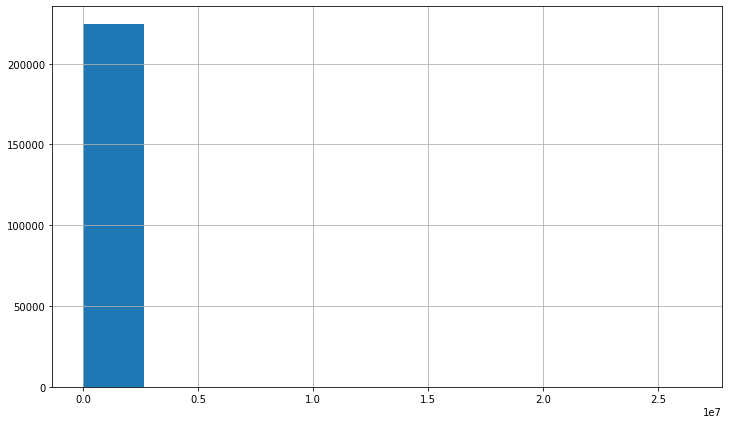

In [659]:
# Построим гистограмму распределения признака:
plt.figure(figsize=(12, 7))
estate_data['lotsize'].hist()

In [660]:
# Отфильтруем выбросы.

estate_data.lotsize.loc[outliers_iqr(estate_data.lotsize)].sort_values()

175755        1505
84307         1505
42133         1505
44365         1507
191036        1507
            ...   
37486      4135853
64828      4297726
48239      5544147
213882     8101739
181634    26441940
Name: lotsize, Length: 20960, dtype: int64

In [661]:
# удалим выбросы

estate_data.drop(outliers_iqr(estate_data.lotsize), inplace = True)
estate_data.reset_index(inplace = True, drop = True)

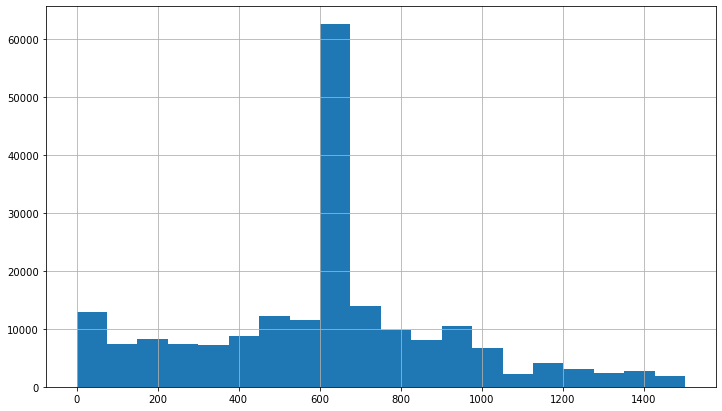

In [662]:
# Построим гистограмму распределения признака:

plt.figure(figsize = (12,7))
estate_data.lotsize.hist(bins=20);

In [663]:
# Извлечем следующий признак 'price/sqft'
estate_data['price/sqft'] = estate_data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

In [664]:
estate_data['price/sqft'].nunique()

5253

In [665]:
estate_data['price/sqft'].isna().sum()

8194

In [666]:
estate_data['price/sqft'].value_counts()[:50]

             2174
$115/sqft     670
$125/sqft     666
$1/sqft       649
$132/sqft     648
$119/sqft     635
$122/sqft     633
$121/sqft     628
$128/sqft     628
$139/sqft     627
$117/sqft     625
$120/sqft     624
$130/sqft     620
$136/sqft     614
$127/sqft     610
$140/sqft     609
$124/sqft     605
$134/sqft     605
$123/sqft     603
$116/sqft     602
$133/sqft     600
$135/sqft     600
$118/sqft     599
$131/sqft     597
$114/sqft     594
$113/sqft     592
$141/sqft     592
$129/sqft     588
$138/sqft     586
$126/sqft     585
$110/sqft     582
$143/sqft     581
$111/sqft     576
$146/sqft     571
$137/sqft     562
$148/sqft     562
$145/sqft     560
$100/sqft     556
$108/sqft     550
$150/sqft     548
$142/sqft     541
$109/sqft     541
$147/sqft     540
$112/sqft     530
$149/sqft     528
$107/sqft     526
$144/sqft     523
$152/sqft     522
$105/sqft     522
$103/sqft     510
Name: price/sqft, dtype: int64

In [667]:
pattern = re.compile('\d+[.]?[,]?\d+')

In [668]:
# Отфильтруем все значения, которые считаются пропусками 
sub_df = estate_data[(estate_data['price/sqft'] != '') & (estate_data['price/sqft'] != 'No Data') & (estate_data['price/sqft'] != 'No Info') & \
            (pd.isna(estate_data['price/sqft']) != True)]

In [669]:
# выделим числовые значения
for i in sub_df.index:
    if len(pattern.findall(sub_df['price/sqft'].loc[i])) != 0:
        sub_df['price/sqft'].loc[i] = pattern.findall(sub_df['price/sqft'].loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

<ipython-input-669-0033a34cee03>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['price/sqft'].loc[i] = pattern.findall(sub_df['price/sqft'].loc[i])[0]


In [670]:
# Убираем запятые

sub_df['price/sqft'] = sub_df['price/sqft'].apply(lambda x: x.replace(',', ''))

<ipython-input-670-e45264d10320>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['price/sqft'] = sub_df['price/sqft'].apply(lambda x: x.replace(',', ''))


In [671]:
# Переводим в числовой формат

sub_df['price/sqft'] = sub_df['price/sqft'].apply(lambda x: int(x))

<ipython-input-671-1bc80ae535f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['price/sqft'] = sub_df['price/sqft'].apply(lambda x: int(x))


In [672]:
# Считаем среднее арифметическое
round(sub_df['price/sqft'].median())

172

In [673]:
# Заменим '', 'No Data', 'No Info' на среднее значение

estate_data['price/sqft'] = estate_data['price/sqft'].apply(lambda x: '172' if (x == '') | (x == 'No Data') | (x == 'No Info') | \
                                          (pd.isna(x) == True) else x)

In [674]:
#  Чтобы получить числовой формат 'price/sqm' снова проделаем данную операцию. 
pattern = re.compile('\d+[.]?[,]?\d+')

In [675]:
# Выделим цифровые значения
estate_data['price/sqft'] = estate_data['price/sqft'].apply(lambda x: '177' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

In [676]:
# Убираем запятые
estate_data['price/sqft'] = estate_data['price/sqft'].apply(lambda x: x.replace(',', ''))

In [677]:
# Переводим в числовой формат
estate_data['price/sqft'] = estate_data['price/sqft'].apply(lambda x: int(x))

In [678]:
# Переводим цены за кв. фут в цены за кв. м.
estate_data['price/sqm'] = estate_data['price/sqft'].apply(lambda x: round(x*10.764))

In [679]:
#estate_data['price/sqm'] = estate_data['price/sqft'].apply(lambda x: round(x*10.764))

In [680]:
# Удаляем столбец 'price/sqft'
estate_data.drop('price/sqft', axis = 1, inplace = True)

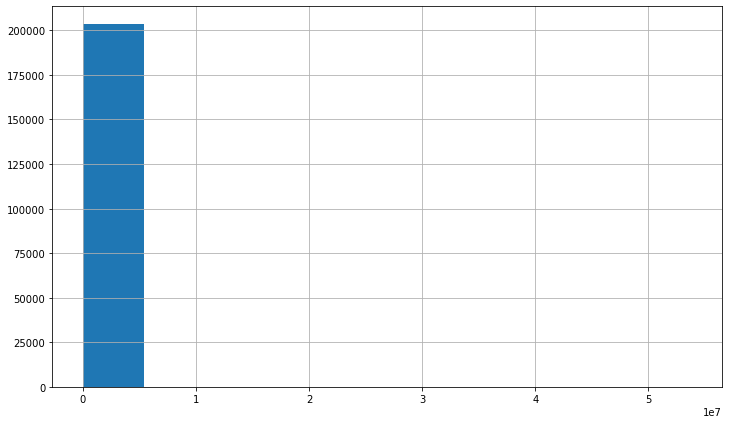

In [681]:
# Построим гистограмму

plt.figure(figsize = (12,7))
estate_data['price/sqm'].hist();

In [682]:
# Отфильтруем выбросы

estate_data['price/sqm'].loc[outliers_iqr(estate_data['price/sqm'])].sort_values()

36267         5264
165885        5264
137119        5264
21995         5264
5796          5264
            ...   
105273     9461556
158040     9569196
130421     9686524
33798     10225800
174113    53820000
Name: price/sqm, Length: 20164, dtype: int64

In [683]:
estate_data.drop(outliers_iqr(estate_data['price/sqm']), inplace = True)
estate_data.reset_index(inplace = True, drop = True)

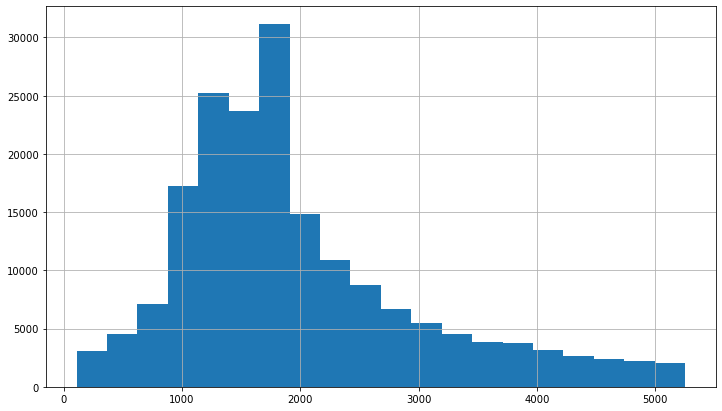

In [684]:
# Построим гистограмму распределения
plt.figure(figsize = (12,7))
estate_data['price/sqm'].hist(bins=20);

In [685]:
estate_data.drop('homeFacts', axis = 1, inplace = True)

### Fireplace

In [686]:
# найдем количество уникальных значений Fireplace

estate_data.fireplace.nunique()

281

In [687]:
estate_data.fireplace.isna().sum()

125402

In [688]:
estate_data.fireplace.value_counts()[:50]

yes                                33409
Yes                                12490
1                                   7695
Not Applicable                      1342
2                                    894
No                                   248
3                                    156
Fireplace YN                         140
Gas/Gas Logs                         132
Wood Burning                          95
Wood                                  94
0                                     72
Living Room                           60
1 Fireplace                           54
Special Features                      53
Living Room, Wood Burning             44
Family Room                           44
Gas                                   34
Family Room, Wood Burning             34
Gas Logs, In Great Room               34
Fireplace Features                    32
4                                     29
N/K                                   26
Gas Logs, In Living Room              23
Electric        

In [689]:
# Заполним все пропуски значением 'no'
estate_data.fireplace = estate_data.fireplace.fillna('no')

In [690]:
# Приведем все значения к нижнему регистру
estate_data['fireplace'] = estate_data['fireplace'].apply(lambda x: str(x).lower())
estate_data.fireplace.value_counts()[:50]

no                                 125650
yes                                 45899
1                                    7695
not applicable                       1342
2                                     894
3                                     156
fireplace yn                          140
gas/gas logs                          132
wood burning                           95
wood                                   94
0                                      72
living room                            60
1 fireplace                            54
special features                       53
family room                            44
living room, wood burning              44
gas logs, in great room                34
family room, wood burning              34
gas                                    34
fireplace features                     32
4                                      29
n/k                                    26
gas logs, in living room               23
electric                          

In [691]:
# Заменим значение 'no' на 0
estate_data['fireplace'] = estate_data['fireplace'].apply(lambda x: 'no' if x=='0' else x)

In [692]:
# Приведем весь столбец к бинарному признаку, заменим все значения, которые != 'no' на 'yes'
estate_data['fireplace'] = estate_data['fireplace'].apply(lambda x: 'yes' if x!='no' else x)

### City

In [693]:
# посмотрим сколько уникальных значений в столбце 'City'
estate_data.city.nunique()

1402

In [694]:
estate_data.city.isna().sum()

1

In [695]:
estate_data.city.value_counts()[:50]

Houston              16235
San Antonio           7659
Dallas                5949
Miami                 5087
Jacksonville          4844
Chicago               4575
Las Vegas             4567
Fort Worth            3904
Orlando               3419
Tampa                 3276
Philadelphia          3175
Austin                3166
Atlanta               2513
Detroit               2348
Charlotte             2336
Cleveland             2173
Fort Lauderdale       2172
Kissimmee             1994
Nashville             1964
Saint Petersburg      1847
Indianapolis          1758
El Paso               1658
Ocala                 1648
Raleigh               1408
Denver                1382
Portland              1374
Palm Coast            1363
Washington            1198
Cape Coral            1186
Brooklyn              1168
Port Charlotte        1167
Reno                  1141
Sacramento            1000
Memphis               1000
Durham                 987
Fresno                 980
Seattle                920
C

In [696]:
# Заполним пропуски самым популярным городом 'Houston'

estate_data['city'] = estate_data['city'].fillna('Houston')
estate_data.city.value_counts()[:10]

Houston         16236
San Antonio      7659
Dallas           5949
Miami            5087
Jacksonville     4844
Chicago          4575
Las Vegas        4567
Fort Worth       3904
Orlando          3419
Tampa            3276
Name: city, dtype: int64

In [697]:
estate_data.city.value_counts()[:10]

Houston         16236
San Antonio      7659
Dallas           5949
Miami            5087
Jacksonville     4844
Chicago          4575
Las Vegas        4567
Fort Worth       3904
Orlando          3419
Tampa            3276
Name: city, dtype: int64

In [698]:
cities_with_freqs = list(estate_data.city.value_counts())
top_cities_count = int(np.percentile(cities_with_freqs, 50))
top_cities_count

11

In [699]:
# Выделим 11 самых популярных городов, которые описывают около 50% примеров. 
all_cities = set(estate_data.city.value_counts().index)
main_cities = set(estate_data.city.value_counts().index[:11])
cities_to_drop = list(all_cities - main_cities)
estate_data.loc[estate_data['city'].isin(cities_to_drop), 'city'] = 'other'

### Stories

In [700]:
# Удалим признак stories, так как он является слишком грязным

estate_data = estate_data.drop('stories', axis=1)

In [701]:
estate_data

,status,propertyType,baths,fireplace,city,schools,sqft,beds,target,Pool,Year_built,remodeled,heating,Parking,lotsize,price/sqm
0,for sale,single-family home,3 Baths,no,other,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3 Beds,"$310,000",No,2019.0,no,no_info,no_provided,541,1711
1,for sale,single-family home,8 Baths,yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",5 Beds,"$2,395,000",No,2006.0,yes,forced air,detached garage,764,3993
2,for sale,townhouse,NaN,no,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,2 Beds,"$209,000",No,1920.0,no,forced air,no_provided,63,2508
3,no_provided,Single Family,3,no,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",3,"$311,995",No,2019.0,no,gas,attached garage,191,1744
4,active,English,NaN,no,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...","3,130",NaN,"260,000",No,2015.0,yes,electric,no_provided,531,893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183208,for sale,Single Family,Bathrooms: 2,no,other,"[{'rating': ['2/10', '6/10', '4/10'], 'data': ...","Total interior livable area: 1,907 sqft",3 bd,"$287,999",No,1969.0,yes,forced air,1 space,658,1625
183209,for sale,single-family home,3 Baths,yes,other,"[{'rating': ['6/10', '5/10', '6/10'], 'data': ...","2,505 sqft",5 Beds,"$384,900",No,1950.0,yes,forced air,detached garage,904,1658
183210,for sale,single-family home,3 Baths,yes,Houston,"[{'rating': ['2/10', '3/10', '3/10'], 'data': ...","1,792 sqft",4 Beds,"$280,000",No,1970.0,yes,other,detached garage,613,1679
183211,no_provided,Single Family,2.0,yes,Orlando,"[{'rating': ['3/10', '1/10', '3/10'], 'data': ...","1,829 sqft",3,"$171,306",No,1962.0,yes,forced air,1 space,716,1851


### Schools

In [702]:
# schools    
estate_data.schools.nunique()

150564

In [703]:
estate_data.schools.isna().sum()

0

In [704]:
estate_data.schools.loc[0]

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

In [705]:
# Применим функцию eval для раскодировки списка, в котором заключен словарь.
estate_data.schools = estate_data.schools.apply(eval)

In [706]:
#В данной колонке содержаться данные о школах, расположенных рядом с домом, такие как:
#rating - рейтинги школ, 
#Distance - расстояния до школ, 
#Grades - возрастной уровень школ и 
#name - названия школ. 

In [707]:
estate_data.schools.loc[0]

[{'rating': ['4/10', 'None/10', '4/10'],
  'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'],
   'Grades': ['9-12', '3-8', 'PK-8']},
  'name': ['East Valley High School&Extension',
   'Eastvalley Middle School',
   'Trentwood Elementary School']}]

In [708]:
# Извлечём показатели рейтингов школ в столбец average_school_rating.

In [709]:
estate_data['average_school_rating'] = estate_data['schools'].apply(lambda x: x[0]['rating'])

In [710]:
estate_data['average_school_rating'].isna().sum()

0

In [711]:
for i in range(5):
    print(estate_data['average_school_rating'].loc[i])

['4/10', 'None/10', '4/10']
['9/10', '9/10', '10/10', '9/10']
[]
['4/10', '3/10', '2/10']
['6', '3', '6', '1', '5']


In [712]:
# Извлечем числовой показатель и посчитаем средний рейтинг
pattern = re.compile('\d+')

In [713]:
for i in estate_data.index:
    sum_ratings = 0
    count = 0
    for item in estate_data['average_school_rating'].loc[i]:
        if (len(pattern.findall(item)) != 0) & ('None' not in item):
            sum_ratings += int(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        estate_data['average_school_rating'].loc[i] = 0
    else:
        estate_data['average_school_rating'].loc[i] = round(sum_ratings/count, 1)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [714]:
estate_data['average_school_rating'].value_counts()

4.0    10772
6.0     9962
5.0     9919
3.0     9502
3.3     8379
       ...  
8.6        8
1.4        7
1.2        1
6.9        1
3.9        1
Name: average_school_rating, Length: 82, dtype: int64

In [715]:
# Посмотрим сколько в столбце нулевых значений
len(estate_data[estate_data['average_school_rating'] == 0])

1401

In [716]:
# Подсчитаем среднее значение
round(estate_data[estate_data['average_school_rating'] != 0]['average_school_rating'].median())

5.0

In [717]:
# Заменим средним арифметическим нулевые значения
estate_data['average_school_rating'] = estate_data['average_school_rating'].apply(lambda x: 5 if x == 0 else x)

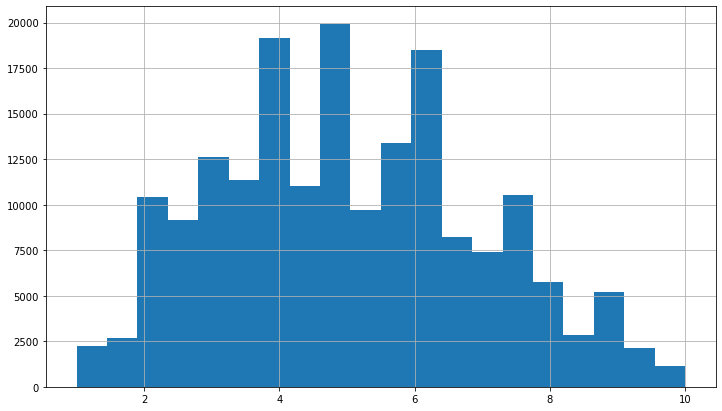

In [718]:
# Посмотрим гистограмму распределения

plt.figure(figsize = (12,7))
estate_data['average_school_rating'].hist(bins=20);

In [719]:
# Количество рядом расположенных школ - 'number_of_schools

estate_data['number_of_schools'] = estate_data['schools'].apply(lambda x: len(x[0]['rating']))

In [720]:
type(estate_data['number_of_schools'][0])

numpy.int64

In [721]:
estate_data['number_of_schools'].value_counts()

3     114792
2      18689
8      13743
4      10596
5       8250
1       4346
6       4071
7       1610
24      1485
0       1035
13       839
63       645
12       559
11       468
15       406
10       351
14       339
22       329
65       312
49       200
61        97
16        19
9         16
21         9
17         5
19         2
Name: number_of_schools, dtype: int64

In [722]:
round(estate_data['number_of_schools'].median())

3

In [723]:
# Заменим нулевые значения на медианное

estate_data['number_of_schools'] = estate_data['number_of_schools'].apply(lambda x: 3 if x == 0 else x)
estate_data['number_of_schools'].value_counts()

3     115827
2      18689
8      13743
4      10596
5       8250
1       4346
6       4071
7       1610
24      1485
13       839
63       645
12       559
11       468
15       406
10       351
14       339
22       329
65       312
49       200
61        97
16        19
9         16
21         9
17         5
19         2
Name: number_of_schools, dtype: int64

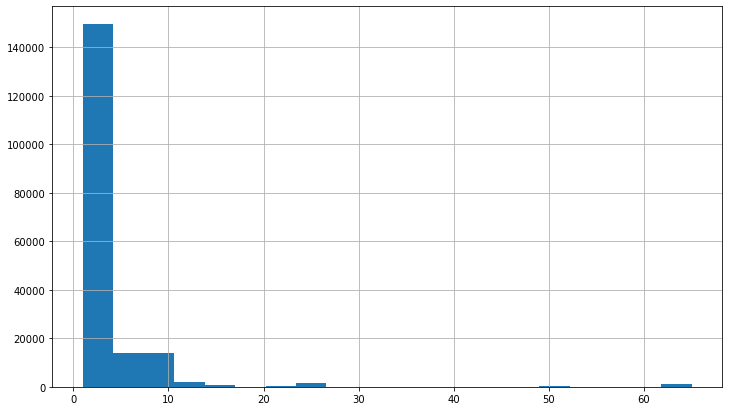

In [724]:
# Посмотрим на гистограмму распределения
plt.figure(figsize = (12,7))
estate_data['number_of_schools'].hist(bins = 20);

In [725]:
# Визуально заметны выбросы; отфильтруем их функцией outliers_z_score
estate_data['number_of_schools'].loc[outliers_z_score(estate_data['number_of_schools'], threshold = 2)].sort_values()

173455    16
176474    16
51394     16
176227    16
48848     16
          ..
168121    65
22957     65
167978    65
58490     65
97546     65
Name: number_of_schools, Length: 3103, dtype: int64

In [726]:
# Удалим выбросы

estate_data.drop(outliers_z_score(estate_data['number_of_schools'], threshold = 2), inplace = True)
estate_data.reset_index(inplace = True, drop = True)

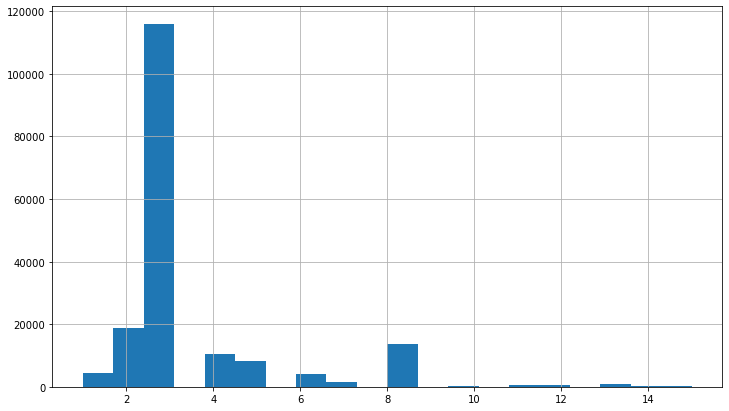

In [727]:
# Построим гистограмму

plt.figure(figsize = (12,7))
estate_data['number_of_schools'].hist(bins = 20);

In [728]:
# Среднее расстояние до школ в милях - 'average_distance_to_school'.

estate_data['average_distance_to_school'] = estate_data['schools'].apply(lambda x: x[0]['data']['Distance'])

In [729]:
estate_data['average_distance_to_school'].isna().sum()

0

In [730]:
for i in range(5):
    print(estate_data['average_distance_to_school'].loc[i])

['1.65mi', '1.32mi', '1.01mi']
['1.05mi', '0.1mi', '1.05mi', '0.81mi']
[]
['0.7 mi', '0.6 mi', '1.9 mi']
['0.4 mi', '0.4 mi', '3.0 mi', '3.2 mi', '7.4 mi']


In [731]:
# Извлечем числовой показатель и посчитаем среднее растояние до окружающих школ.

pattern = re.compile('\d+[.]\d+')

In [732]:
for i in estate_data.index:
    sum_distances = 0
    count = 0
    for item in estate_data['average_distance_to_school'].loc[i]:
        if len(pattern.findall(item)) != 0:
            sum_distances += float(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        estate_data['average_distance_to_school'].loc[i] = 0
    else:
        estate_data['average_distance_to_school'].loc[i] = round(sum_distances/count, 1)

In [733]:
estate_data['average_distance_to_school'].value_counts()

1.1     8537
0.9     7890
1.2     7888
1.0     7880
0.8     7355
        ... 
23.0       1
40.3       1
36.3       1
33.3       1
26.2       1
Name: average_distance_to_school, Length: 293, dtype: int64

In [734]:
# Посмотрим сколько в столбце нулевых значений.

len(estate_data[estate_data['average_distance_to_school'] == 0])

1229

In [735]:
# Отфильтруем нули в столбце и посчитаем среднее
round(estate_data[estate_data['average_distance_to_school'] != 0]['average_distance_to_school'].median())

2.0

In [736]:
estate_data['average_distance_to_school'] = estate_data['average_distance_to_school'].apply(lambda x: 2 if x == 0 else x)

In [737]:
# Переводим мили в км.

estate_data['average_distance_to_school'] = estate_data['average_distance_to_school'].apply(lambda x: x*1.6)

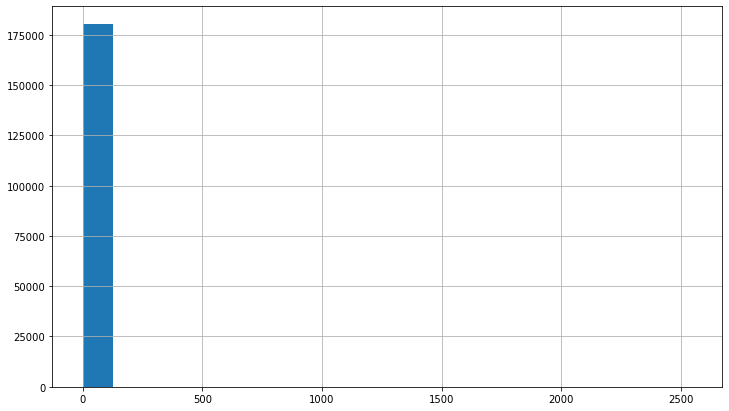

In [738]:
# Построим гистограмму распределения
plt.figure(figsize = (12,7))
estate_data['average_distance_to_school'].hist(bins=20);

In [739]:
# Отфильтруем выбросы при помощи outliers_igr
estate_data['average_distance_to_school'].loc[outliers_iqr(estate_data['average_distance_to_school'])].sort_values()

55411        9.12
104203       9.12
104008       9.12
177292       9.12
127594       9.12
           ...   
110299    1160.80
177624    1160.80
170743    1160.80
170474    2545.28
52392     2545.28
Name: average_distance_to_school, Length: 16050, dtype: float64

In [740]:
# Удалим выбросы

estate_data = estate_data.drop(outliers_iqr(estate_data['average_distance_to_school']))
estate_data.reset_index(inplace = True, drop = True)

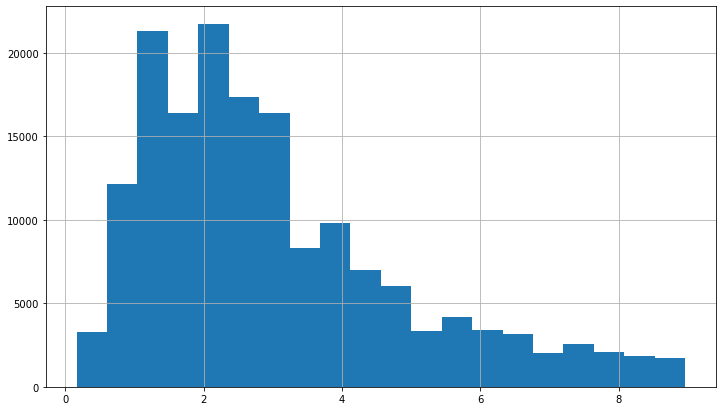

In [741]:
# Построим гистограмму
plt.figure(figsize = (12,7))
estate_data['average_distance_to_school'].hist(bins=20);

In [742]:
# На основе гистограммы выяснилось, что распределение имеет правый хвост. 

In [743]:

estate_data.drop('schools', axis = 1, inplace = True)

### Sqrt

In [744]:
# Определим количество уникальных значений
estate_data.sqft.nunique()

17544

In [745]:
estate_data.sqft.value_counts()[:50]

0             2259
1,200 sqft     461
1,000 sqft     340
1,800 sqft     338
1,500 sqft     329
1,100 sqft     321
2,000 sqft     308
1,400 sqft     298
1,600 sqft     284
1,440 sqft     249
1,300 sqft     243
960 sqft       235
2,400 sqft     228
2,200 sqft     224
-- sqft        217
2,100 sqft     195
800 sqft       195
3,000 sqft     194
900 sqft       194
1,152 sqft     191
1,120 sqft     189
1,344 sqft     188
1,320 sqft     181
1,700 sqft     175
2,500 sqft     174
1,250 sqft     170
1,900 sqft     166
1,056 sqft     163
1,080 sqft     156
1,350 sqft     156
2,300 sqft     155
1,248 sqft     151
1,296 sqft     150
1,260 sqft     150
1,450 sqft     147
1,650 sqft     144
1,050 sqft     143
850 sqft       142
1,680 sqft     142
1,008 sqft     136
2,600 sqft     133
840 sqft       130
950 sqft       129
1,170 sqft     128
1,040 sqft     127
1,560 sqft     126
1,512 sqft     119
1,280 sqft     119
--             118
1,750 sqft     118
Name: sqft, dtype: int64

In [746]:
#Преобразуем столбец в числовой тип данных и заполним пропуски и значения, которые будем считать пропусками, 
#средним арифметическим. Пропусками также будем считать значения '0', '--' и '-- sqft'. 
#Сначала отфильтруем пропуски и все значения, которые считаем пропусками, затем преобразуем столбец в числовой формат,
#переведём все значения в квадратные метры (m^2) и посчитаем медиану.


pattern = re.compile('\d+[,]?\d+')

In [747]:
# Отфильтруем все значения, которые считаются пропусками

sub_df = estate_data[(estate_data.sqft != '0') & (estate_data.sqft != '--') & (estate_data.sqft != '-- sqft') & (pd.isna(estate_data.sqft) != True)]

In [748]:
# Выделим числовое значение

for i in sub_df.index:
    if len(pattern.findall(sub_df.sqft.loc[i])) != 0:
        sub_df['sqft'].loc[i] = pattern.findall(sub_df.sqft.loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

<ipython-input-748-cf96bfde7c39>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['sqft'].loc[i] = pattern.findall(sub_df.sqft.loc[i])[0]
C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [749]:
# Удаляем запятые

sub_df['sqft'] = sub_df['sqft'].apply(lambda x: x.replace(',', ''))

<ipython-input-749-bfe2b6654c6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['sqft'] = sub_df['sqft'].apply(lambda x: x.replace(',', ''))


In [750]:
# Переводим в числовой формат

sub_df['sqft'] = sub_df['sqft'].apply(lambda x: int(x))

<ipython-input-750-4fde386a8d43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['sqft'] = sub_df['sqft'].apply(lambda x: int(x))


In [751]:
# Считаем среднее по столбцу
round(sub_df['sqft'].median())

1888

In [752]:
# Заменим пропуски и значения '0', '--', '--sqrt' на среднее значение по столбцу

estate_data['sqft'] = estate_data['sqft'].apply(lambda x: '1888' if (x == '0') | (x == '--') | (x == '-- sqft') | (pd.isna(x) == True) else x)

In [753]:
# Производим те же операции для получения числового формата с размерностью m^2
pattern = re.compile('\d+[,]?\d+')

In [754]:
# Выделяем числовые значения

estate_data['sqft'] = estate_data['sqft'].apply(lambda x: '1888' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

In [755]:
# Убираем запятые
estate_data['sqft'] = estate_data['sqft'].apply(lambda x: x.replace(',', ''))

In [756]:
# Переводим в числовой формат
estate_data['sqft'] = estate_data['sqft'].apply(lambda x: int(x))

In [757]:
# Переводим все к размерности [кв.м.]

estate_data['sqm'] = estate_data['sqft'].apply(lambda x: round(x/10.764))

In [758]:
# Удаляем столбец sqft
estate_data.drop('sqft', axis = 1, inplace = True)

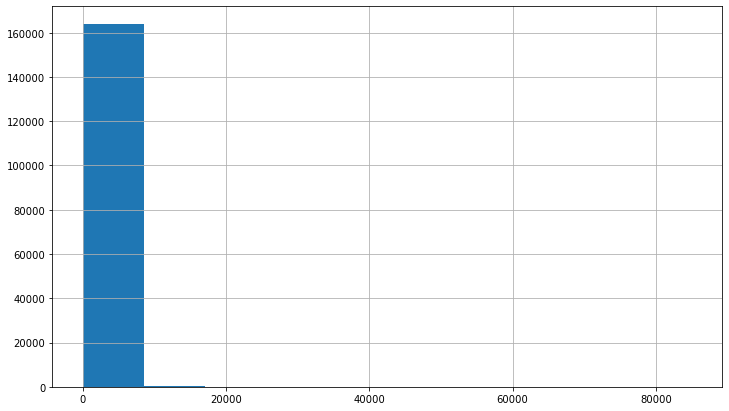

In [759]:
# Строим гистограмму распределения
plt.figure(figsize = (12,7))
estate_data.sqm.hist();

In [760]:
# Отфильтруем выбросы.

estate_data.sqm.loc[outliers_iqr(estate_data.sqm)].sort_values()

10157       398
109360      398
95102       398
159249      398
134370      398
          ...  
148245    66741
89990     66741
37622     66741
53484     73774
155566    84998
Name: sqm, Length: 7132, dtype: int64

In [761]:
# Удаление выбросов

estate_data.drop(outliers_iqr(estate_data.sqm), inplace = True)
estate_data.reset_index(inplace = True, drop = True)

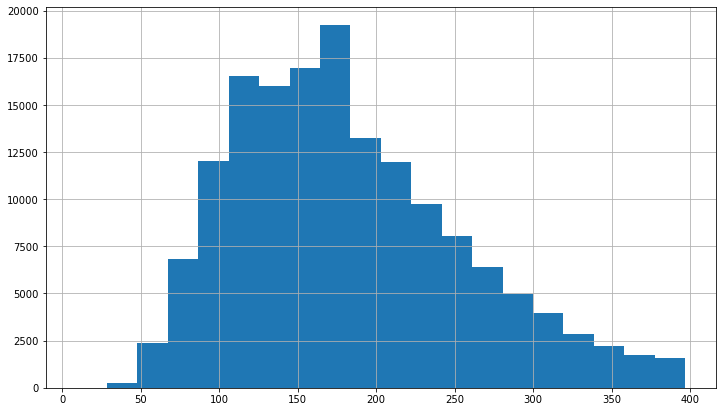

In [762]:
plt.figure(figsize = (12,7))
estate_data.sqm.hist(bins=20);

In [763]:
estate_data.beds.value_counts()[:50]

3 Beds        35704
4 Beds        22640
2 Beds        14546
3             13995
4              8762
3 bd           8683
Baths          6394
4 bd           5421
5 Beds         5218
2              5135
2 bd           3444
3.0            3010
5              2020
4.0            1793
6 Beds         1376
5 bd           1298
1               933
2.0             674
1 bd            611
7 Beds          361
-- bd           360
6               331
8 Beds          311
5.0             266
6 bd            232
Bath            203
0               196
9 Beds          134
6.0              79
7                63
                 62
1.0              61
10 Beds          56
8                45
7 bd             39
8 bd             34
12 Beds          29
0.0              21
11 Beds          20
9                11
9 bd             11
8.0               9
7.0               6
10 bd             6
10                5
16 Beds           3
8,276 sqft        3
11 bd             3
12                2
10.0              2


Признак beds является слишком грязным с большим количеством пропуском, поэтому его стоит удалить

In [764]:
estate_data.drop('beds', axis = 1, inplace = True)

### Target

In [765]:
# число уникальных значений в target 

estate_data.target.nunique()

22885

In [766]:
estate_data.target.isna().sum()

707

In [767]:
estate_data.target.value_counts()[:50]

$225,000    781
$275,000    715
$249,900    711
$299,900    705
$199,900    695
$325,000    657
$250,000    650
$350,000    619
$399,000    605
$215,000    588
$299,000    579
$235,000    577
$375,000    574
$175,000    574
$425,000    567
$399,900    552
$265,000    551
$239,900    542
$165,000    537
$185,000    536
$285,000    533
$349,900    529
$179,900    518
$315,000    518
$169,900    513
$450,000    505
$189,900    499
$499,000    498
$149,900    497
$269,900    493
$259,900    489
$245,000    487
$159,900    473
$295,000    458
$210,000    457
$220,000    454
$229,900    443
$279,900    432
$289,900    427
$195,000    425
$150,000    425
$219,900    424
$139,900    421
$599,000    409
$145,000    406
$1,000      404
$125,000    396
$300,000    394
$525,000    392
$475,000    391
Name: target, dtype: int64

In [768]:
# Преобразуем столбец в числовой тип данных и заполним пропуски медианой. 
# Сначала отфильтруем пропуски, затем преобразуем столбец в числовой формат и посчитаем среднее арифметическое.

pattern = re.compile('\d+[,]?\d+')

In [769]:
# Отфильтруем пропуски
sub_df = estate_data[pd.isna(estate_data.target) != True]

In [770]:
# Выделим числовое значение
for i in sub_df.index:
    if len(pattern.findall(sub_df.target.loc[i])) != 0:
        sub_df['target'].loc[i] = pattern.findall(sub_df.target.loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

<ipython-input-770-0e40447c8c5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'].loc[i] = pattern.findall(sub_df.target.loc[i])[0]


In [771]:
# Убираем запятые
sub_df['target'] = sub_df['target'].apply(lambda x: x.replace(',', ''))


<ipython-input-771-90c05b1dbaab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'] = sub_df['target'].apply(lambda x: x.replace(',', ''))


In [772]:
# Переводим в числовой формат
sub_df['target'] = sub_df['target'].apply(lambda x: int(x))

<ipython-input-772-d404f2e5ad37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'] = sub_df['target'].apply(lambda x: int(x))


In [773]:
# Подсчитаем среднее значение по столбцу
round(sub_df['target'].median())

279000

In [774]:
# Заполним пропуски на '279000'
estate_data['target'] = estate_data['target'].fillna('279000')

In [775]:
# Проделаем операции для получения числового формата

pattern = re.compile('\d+[,]?\d+')

In [776]:
# Выделяем цифровой показатель
estate_data['target'] = estate_data['target'].apply(lambda x: '279000' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

In [777]:
# Убираем запятые
estate_data['target'] = estate_data['target'].apply(lambda x: x.replace(',', ''))

In [778]:
# Переводим в числовой формат
estate_data['target'] = estate_data['target'].apply(lambda x: int(x))

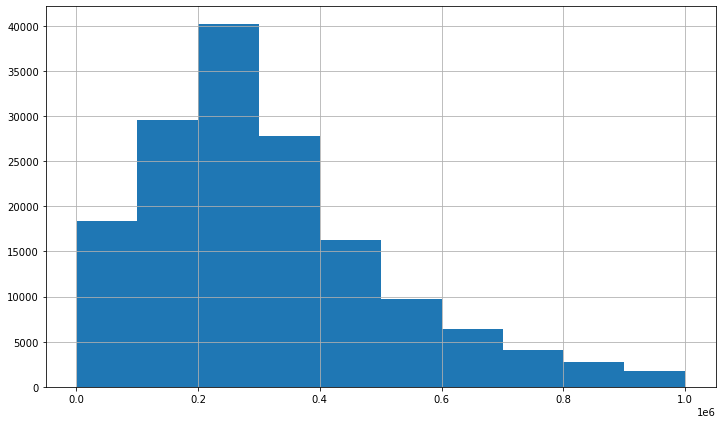

In [779]:
# Гистограмму распределения признака:

plt.figure(figsize = (12,7))
estate_data.target.hist();

In [780]:
# Отфильтруем выбросы

estate_data.target.loc[outliers_iqr(estate_data.target)].sort_values()

22262     767690
136342    767932
57175     768000
138121    768000
53874     768000
           ...  
70770     999999
129216    999999
67312     999999
119708    999999
152006    999999
Name: target, Length: 6225, dtype: int64

In [781]:
# Удалим выбросы
estate_data = estate_data.drop(outliers_iqr(estate_data.target))
estate_data.reset_index(inplace = True, drop = True)

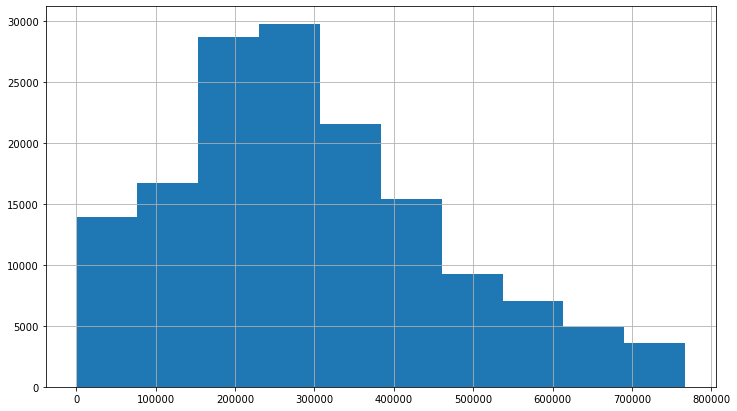

In [782]:
# Построим гистограмму

plt.figure(figsize = (12,7))
estate_data.target.hist()

In [783]:
estate_data.shape

(150703, 17)

In [784]:
estate_data.shape

(150703, 17)

### baths

In [785]:
estate_data.baths.value_counts()[:50]

2 Baths         32603
3 Baths         22303
2                8381
4 Baths          7305
Bathrooms: 2     6567
2.0              6201
3                4642
Bathrooms: 3     4610
3.0              4431
2.5 Baths        3747
2.5              2765
1                2033
Bathrooms: 1     2028
2 ba             1982
0                1974
1.0              1717
4.0              1670
4                1427
3.5 Baths        1358
3 ba             1350
Bathrooms: 4     1330
5 Baths          1247
3.5              1000
3,000             957
1,500             950
2,000             796
1,750             700
2,250             671
1,250             611
1.5               602
1 ba              511
4 ba              397
2,750             345
2,500             313
6 Baths           312
-- baths          274
5                 244
5.0               228
Bathrooms: 5      225
1,000             223
3,500             202
4.5 Baths         178
4.5               159
1.5 Baths         137
750               132
~         

In [786]:
# Посмотрим уникальные значения в столбце
estate_data['baths'].unique()

array(['3 Baths', nan, '3', 'Bathrooms: 2', '1,750', '4 Baths', '2 ba',
       '2 Baths', '3.0', 'Bathrooms: 1', '2.1 Baths', '2.5 Baths', '1',
       'Bathrooms: 3', '2.0', 'Bathrooms: 4', '2', '3 ba', '5.5 Baths',
       '1.0', '1.5', '6 Baths', '2.5', '3.5 Baths', '8 Baths', '3.5 ba',
       '0', '2,000', '1,500', '1,250', '3.5', '1 ba', '2,250', '4.0',
       '1.5 Baths', '2,750', '4', '~', '3,000', '4.5 Baths', '750',
       '1.5 ba', 'Bathrooms: 6', '4 ba', '2.5+', '4.5', '5 Baths',
       '0 / 0', '1,000', 'Sq. Ft. ', '-- baths', '5', 'Bathrooms: 5', '6',
       '5,000', '5.0', '3,500', '1.1 Baths', '2,500', '19 Baths',
       '13 Baths', 'Bathrooms: 7', '1.75 Baths', '12 Baths', '2.5 ba',
       'Bathrooms: 241', '6.0', '7 Baths', '8.0', '6.5', '5 ba', '1.5+',
       '7,500+', '7', '7 ba', '4,000', '5.5', '2.75 Baths', '4.5+',
       '2.25 Baths', '3.1 Baths', '0.00', '24 Baths', '3.5+', '10 Baths',
       '0.0', '10', 'Bathrooms: 8', '2 baths', '3.75 Baths', '6 ba',
       '5.

In [787]:
# Преобразование данных о ванной

estate_data['baths'] = estate_data['baths'].fillna('1000')

In [788]:
#Преобразуем данный признак в числовой. Он будет содержать количество полных ванных комнат в доме. 
#Для этого сначала обработаем пропуски и значения '-- baths', '—', 'Sq. Ft. ', '~', которые не содержат цифр и фактически означают пропущенные значения. 
#Заменим эти значения на '1000', и пропуски так же заполним значением '1000'. 
#Затем удалим непонятные значения, представленные в малом количестве, такие как: '2-1 / 2-1 / 1-1 / 1-1', '1 / 1-0 / 1-0 / 1-0', '1 / 1 / 1 / 1', '3-1 / 2-2', 'Bathrooms: SemiMod', 'Bathrooms: 241', '1-0 / 1-0 / 1', '116 / 116 / 116', '750'.

estate_data['baths'] = estate_data['baths'].apply(lambda x: '1000' if (x=='-- baths') | (x=='—') | (x=='Sq. Ft. ') | (x=='~') else x)
estate_data = estate_data.drop(estate_data[(estate_data.baths=='2-1 / 2-1 / 1-1 / 1-1') | (estate_data.baths=='1 / 1-0 / 1-0 / 1-0') | (estate_data.baths=='1 / 1 / 1 / 1') | \
                (estate_data.baths=='3-1 / 2-2') | (estate_data.baths=='Bathrooms: SemiMod') | (estate_data.baths=='Bathrooms: 241') | \
                (estate_data.baths=='1-0 / 1-0 / 1') | (estate_data.baths=='116 / 116 / 116') | (estate_data.baths=='750')].index)


In [789]:
estate_data.reset_index(inplace = True, drop = True)

In [790]:
estate_data.baths.unique()

array(['3 Baths', '1000', '3', 'Bathrooms: 2', '1,750', '4 Baths', '2 ba',
       '2 Baths', '3.0', 'Bathrooms: 1', '2.1 Baths', '2.5 Baths', '1',
       'Bathrooms: 3', '2.0', 'Bathrooms: 4', '2', '3 ba', '5.5 Baths',
       '1.0', '1.5', '6 Baths', '2.5', '3.5 Baths', '8 Baths', '3.5 ba',
       '0', '2,000', '1,500', '1,250', '3.5', '1 ba', '2,250', '4.0',
       '1.5 Baths', '2,750', '4', '3,000', '4.5 Baths', '1.5 ba',
       'Bathrooms: 6', '4 ba', '2.5+', '4.5', '5 Baths', '0 / 0', '1,000',
       '5', 'Bathrooms: 5', '6', '5,000', '5.0', '3,500', '1.1 Baths',
       '2,500', '19 Baths', '13 Baths', 'Bathrooms: 7', '1.75 Baths',
       '12 Baths', '2.5 ba', '6.0', '7 Baths', '8.0', '6.5', '5 ba',
       '1.5+', '7,500+', '7', '7 ba', '4,000', '5.5', '2.75 Baths',
       '4.5+', '2.25 Baths', '3.1 Baths', '0.00', '24 Baths', '3.5+',
       '10 Baths', '0.0', '10', 'Bathrooms: 8', '2 baths', '3.75 Baths',
       '6 ba', '5.5+', '12 ba', 'Bathrooms: 11', '2.25 ba', '7.0',
       '3

In [791]:
# Создадим признак bathrooms, который будет содержать количество полных ванных комнат.

pattern = re.compile('\d+')
estate_data['bathrooms'] = estate_data['baths'].apply(lambda x: int(pattern.findall(x)[0]))

In [792]:
estate_data['bathrooms'].value_counts().index.sort_values()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
              11,   12,   13,   14,   15,   16,   18,   19,   20,   24,   30,
            1000],
           dtype='int64')

In [793]:
# сделаем данный признак категориальным, разбив количество ванных комнат по диапазону.
# отсутствующие значения закодируем значением 'no_provided'
for i in estate_data.index:
    if estate_data['bathrooms'].loc[i] == 0:
        estate_data['bathrooms'].loc[i] = 'no'
    elif estate_data['bathrooms'].loc[i]  == 1:
        estate_data['bathrooms'].loc[i] = '1'
    elif estate_data['bathrooms'].loc[i] == 2:
        estate_data['bathrooms'].loc[i] = '2'
    elif (estate_data['bathrooms'].loc[i] > 2) & (estate_data['bathrooms'].loc[i] < 1000):
        estate_data['bathrooms'].loc[i] = 'more_than_2'
    elif estate_data['bathrooms'].loc[i] == 1000:
        estate_data['bathrooms'].loc[i] = 'no_provided'

In [794]:
# Удалим столбец baths
estate_data.drop('baths', axis = 1, inplace = True)

In [795]:
estate_data['propertyType'].nunique()

458

In [796]:
estate_data['propertyType'].isna().sum()

2625

In [797]:
estate_data['propertyType'].fillna('no_provided')
estate_data['propertyType'].value_counts()[:50]

single-family home                      55717
Single Family                           32231
Single Family Home                      10385
condo                                   10058
townhouse                                8682
Condo                                    5126
Townhouse                                3605
Traditional                              3406
multi-family                             2915
Land                                     2050
Condo/Townhome/Row Home/Co-Op            1611
lot/land                                 1473
mobile/manufactured                      1029
Single Detached, Traditional              941
Multi Family                              916
coop                                      707
Mobile / Manufactured                     648
Contemporary/Modern                       638
Ranch                                     463
Contemporary                              446
Single Detached                           416
Multi-Family Home                 

### propertyType 

In [798]:
# приведем значения столбца к нижнему регистру
estate_data['propertyType'] = estate_data['propertyType'].apply(lambda x: str(x).lower())

In [799]:
estate_data['propertyType'].value_counts()[:50]

single-family home                      55717
single family                           32231
condo                                   15184
townhouse                               12287
single family home                      10385
traditional                              3406
multi-family                             2925
nan                                      2625
land                                     2050
condo/townhome/row home/co-op            1611
lot/land                                 1473
mobile/manufactured                      1029
single detached, traditional              941
multi family                              916
coop                                      707
mobile / manufactured                     648
contemporary/modern                       638
ranch                                     463
contemporary                              446
single detached                           416
multi-family home                         358
mfd/mobile home                   

In [800]:
# Приведем к единообразию некоторые значения.

estate_data['propertyType'] = estate_data['propertyType'].apply(lambda x: 'single-family' if (x=='single family') | (x=='single family home') |
                                             (x == 'single-family home') else x)
estate_data['propertyType'] = estate_data['propertyType'].apply(lambda x: 'multi-family' if (x=='multi family') | (x == 'multi-family home') else x)
estate_data['propertyType'] = estate_data['propertyType'].apply(lambda x: '1 story' if x=='one story' else x)
estate_data['propertyType'] = estate_data['propertyType'].apply(lambda x: '2 stories' if (x=='2 story') | (x=='two story')  else x)
estate_data['propertyType'] = estate_data['propertyType'].apply(lambda x: 'land' if x=='lot/land'  else x)

In [801]:
estate_data['propertyType'].value_counts()[:50]

single-family                           98333
condo                                   15184
townhouse                               12287
multi-family                             4199
land                                     3523
traditional                              3406
nan                                      2625
condo/townhome/row home/co-op            1611
mobile/manufactured                      1029
single detached, traditional              941
coop                                      707
mobile / manufactured                     648
contemporary/modern                       638
ranch                                     463
contemporary                              446
single detached                           416
mfd/mobile home                           251
transitional                              210
florida                                   181
colonial                                  162
singlefamilyresidence                     159
other style                       

In [802]:
# Приведем к единообразию некоторые значения.

estate_data['propertyType'] = estate_data['propertyType'].replace(['condominium (single level), contemporary', 'condo/townhome, traditional', 'condominium (single level)', 'condo/townhome, contemporary/modern', 'condo/townhome/row home/co-op', 'condo/townhome'], 'condo')

In [803]:
estate_data['propertyType'].value_counts()[:50]

single-family                           98333
condo                                   17171
townhouse                               12287
multi-family                             4199
land                                     3523
traditional                              3406
nan                                      2625
mobile/manufactured                      1029
single detached, traditional              941
coop                                      707
mobile / manufactured                     648
contemporary/modern                       638
ranch                                     463
contemporary                              446
single detached                           416
mfd/mobile home                           251
transitional                              210
florida                                   181
colonial                                  162
singlefamilyresidence                     159
other style                               150
apartment                         

In [804]:
freq_propertyTypes = list(estate_data.propertyType.value_counts())
top_propertyTypes_count = int(np.percentile(freq_propertyTypes, 75))
top_propertyTypes_count

5

In [805]:
# Оставим только 5 самых популярных значений, которые описывают 75%, остальные удалим.

fulllist_propertyTypes = set(estate_data['propertyType'].value_counts().index)
main_Types = set(estate_data['propertyType'].value_counts().index[:5])
drop_propertyTypes = list(fulllist_propertyTypes - main_Types)
estate_data.drop(estate_data.loc[estate_data['propertyType'].isin(drop_propertyTypes), 'propertyType'].index, inplace = True)

In [806]:
estate_data['propertyType'].value_counts()[:10]

single-family    98333
condo            17171
townhouse        12287
multi-family      4199
land              3523
Name: propertyType, dtype: int64

### Feature engineering


In [807]:
# создадим полиномиальные признаки на основе столбцов sqm и price/sqm.

pf = PolynomialFeatures(2)

poly_features = pf.fit_transform(estate_data[['sqm', 'price/sqm']])
new_df = pd.DataFrame(poly_features, columns = ['1', 'sqm', 'price/sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2'])
new_df.drop(['1', 'sqm', 'price/sqm'], axis = 1, inplace = True)
estate_data = pd.concat([estate_data, new_df], axis = 1)

In [808]:
# Мы получили еще 3 числовых признака

In [809]:
estate_data.shape

(149033, 20)

In [810]:
estate_data.head()

,status,propertyType,fireplace,city,target,Pool,Year_built,remodeled,heating,Parking,lotsize,price/sqm,average_school_rating,number_of_schools,average_distance_to_school,sqm,bathrooms,sqm^2,sqm_price/sqm,price/sqm^2
0,for sale,single-family,no,other,310000.0,No,2019.0,no,no_info,no_provided,541.0,1711.0,4.0,3.0,2.08,181.0,more_than_2,32761.0,309691.0,2927521.0
1,for sale,townhouse,no,Philadelphia,209000.0,No,1920.0,no,forced air,no_provided,63.0,2508.0,5.0,3.0,3.20,83.0,no_provided,6889.0,208164.0,6290064.0
2,no_provided,single-family,no,Houston,311995.0,No,2019.0,no,gas,attached garage,191.0,1744.0,3.0,3.0,1.76,179.0,more_than_2,32041.0,312176.0,3041536.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28561.0,500240.0,8761600.0
4,new construction,single-family,no,other,499900.0,No,2019.0,yes,forced air,attached garage,650.0,2960.0,7.3,3.0,1.76,169.0,2,51984.0,169404.0,552049.0


In [811]:
estate_data = estate_data.replace(('No', 'no'), 0).replace(('Yes', 'yes'), 1)

In [812]:
estate_data.head()

,status,propertyType,fireplace,city,target,Pool,Year_built,remodeled,heating,Parking,lotsize,price/sqm,average_school_rating,number_of_schools,average_distance_to_school,sqm,bathrooms,sqm^2,sqm_price/sqm,price/sqm^2
0,for sale,single-family,0.0,other,310000.0,0.0,2019.0,0.0,no_info,no_provided,541.0,1711.0,4.0,3.0,2.08,181.0,more_than_2,32761.0,309691.0,2927521.0
1,for sale,townhouse,0.0,Philadelphia,209000.0,0.0,1920.0,0.0,forced air,no_provided,63.0,2508.0,5.0,3.0,3.20,83.0,no_provided,6889.0,208164.0,6290064.0
2,no_provided,single-family,0.0,Houston,311995.0,0.0,2019.0,0.0,gas,attached garage,191.0,1744.0,3.0,3.0,1.76,179.0,more_than_2,32041.0,312176.0,3041536.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28561.0,500240.0,8761600.0
4,new construction,single-family,0.0,other,499900.0,0.0,2019.0,1.0,forced air,attached garage,650.0,2960.0,7.3,3.0,1.76,169.0,2,51984.0,169404.0,552049.0


In [813]:
estate_data.isna().sum()

status                        13520
propertyType                  13520
fireplace                     13520
city                          13520
target                        13520
Pool                          13520
Year_built                    13520
remodeled                     13520
heating                       13520
Parking                       13520
lotsize                       13520
price/sqm                     13520
average_school_rating         13520
number_of_schools             13520
average_distance_to_school    13520
sqm                           13520
bathrooms                     13520
sqm^2                         13520
sqm_price/sqm                 13520
price/sqm^2                   13520
dtype: int64

In [814]:
# Cтроки где нулевых значений больше 10-ти
estate_data = estate_data[~(estate_data.isna().sum(axis=1) >= 10)]

In [815]:
estate_data.isna().sum()

status                            0
propertyType                      0
fireplace                         0
city                              0
target                            0
Pool                              0
Year_built                        0
remodeled                         0
heating                           0
Parking                           0
lotsize                           0
price/sqm                         0
average_school_rating             0
number_of_schools                 0
average_distance_to_school        0
sqm                               0
bathrooms                         0
sqm^2                         13520
sqm_price/sqm                 13520
price/sqm^2                   13520
dtype: int64

In [816]:
# Заполним нулевые позиции средним значеним 

estate_data['sqm^2'] = estate_data['sqm^2'].fillna(estate_data['sqm^2'].mean())

In [817]:
# Заполним нулевые позиции средним значенем 

estate_data['price/sqm^2'] = estate_data['price/sqm^2'].fillna(estate_data['price/sqm^2'].mean())

In [818]:
# Заполним нулевые позиции средним значеним 
estate_data['sqm_price/sqm'] = estate_data['sqm_price/sqm'].fillna(estate_data['sqm_price/sqm'].mean())

In [820]:
estate_data.head()

,status,propertyType,fireplace,city,target,Pool,Year_built,remodeled,heating,Parking,lotsize,price/sqm,average_school_rating,number_of_schools,average_distance_to_school,sqm,bathrooms,sqm^2,sqm_price/sqm,price/sqm^2
0,for sale,single-family,0.0,other,310000.0,0.0,2019.0,0.0,no_info,no_provided,541.0,1711.0,4.0,3.0,2.08,181.0,more_than_2,32761.0,309691.0,2927521.0
1,for sale,townhouse,0.0,Philadelphia,209000.0,0.0,1920.0,0.0,forced air,no_provided,63.0,2508.0,5.0,3.0,3.20,83.0,no_provided,6889.0,208164.0,6290064.0
2,no_provided,single-family,0.0,Houston,311995.0,0.0,2019.0,0.0,gas,attached garage,191.0,1744.0,3.0,3.0,1.76,179.0,more_than_2,32041.0,312176.0,3041536.0
4,new construction,single-family,0.0,other,499900.0,0.0,2019.0,1.0,forced air,attached garage,650.0,2960.0,7.3,3.0,1.76,169.0,2,51984.0,169404.0,552049.0
5,no_provided,single-family,0.0,Houston,168800.0,0.0,1982.0,1.0,other,2 spaces,198.0,743.0,5.3,3.0,2.24,228.0,more_than_2,81796.0,366366.0,1640961.0


In [821]:
estate_data.shape

(135513, 20)

In [ ]:
# Выгрузим данные для дальнейшего обучения
estate_data.to_csv('final_dataset.csv', index=False)

В результате EDA получен датасет с размерностью (135513, 20). При этом размерность исходного датасета была (377185, 18).